Urbanization Probability Index System
SDG 11 - Sustainable Cities and Communities

Generating simulated data for 1000 grid cells over 10 years...
Generated 10000 data points
Urbanization rate: 11.22%

Data Summary:
            grid_id          year          ndvi  built_up_index           lst  \
count  10000.000000  10000.000000  10000.000000    10000.000000  10000.000000   
mean     499.500000      4.500000      0.692222        0.109510    289.608004   
std      288.689425      2.872425      0.160763        0.104166      3.131122   
min        0.000000      0.000000      0.141143        0.000000    276.242097   
25%      249.750000      2.000000      0.582994        0.035373    287.541479   
50%      499.500000      4.500000      0.688422        0.082183    289.637001   
75%      749.250000      7.000000      0.800070        0.154737    291.742077   
max      999.000000      9.000000      1.285523        0.850839    302.273505   

       nighttime_lights  road_density  distance_to_city

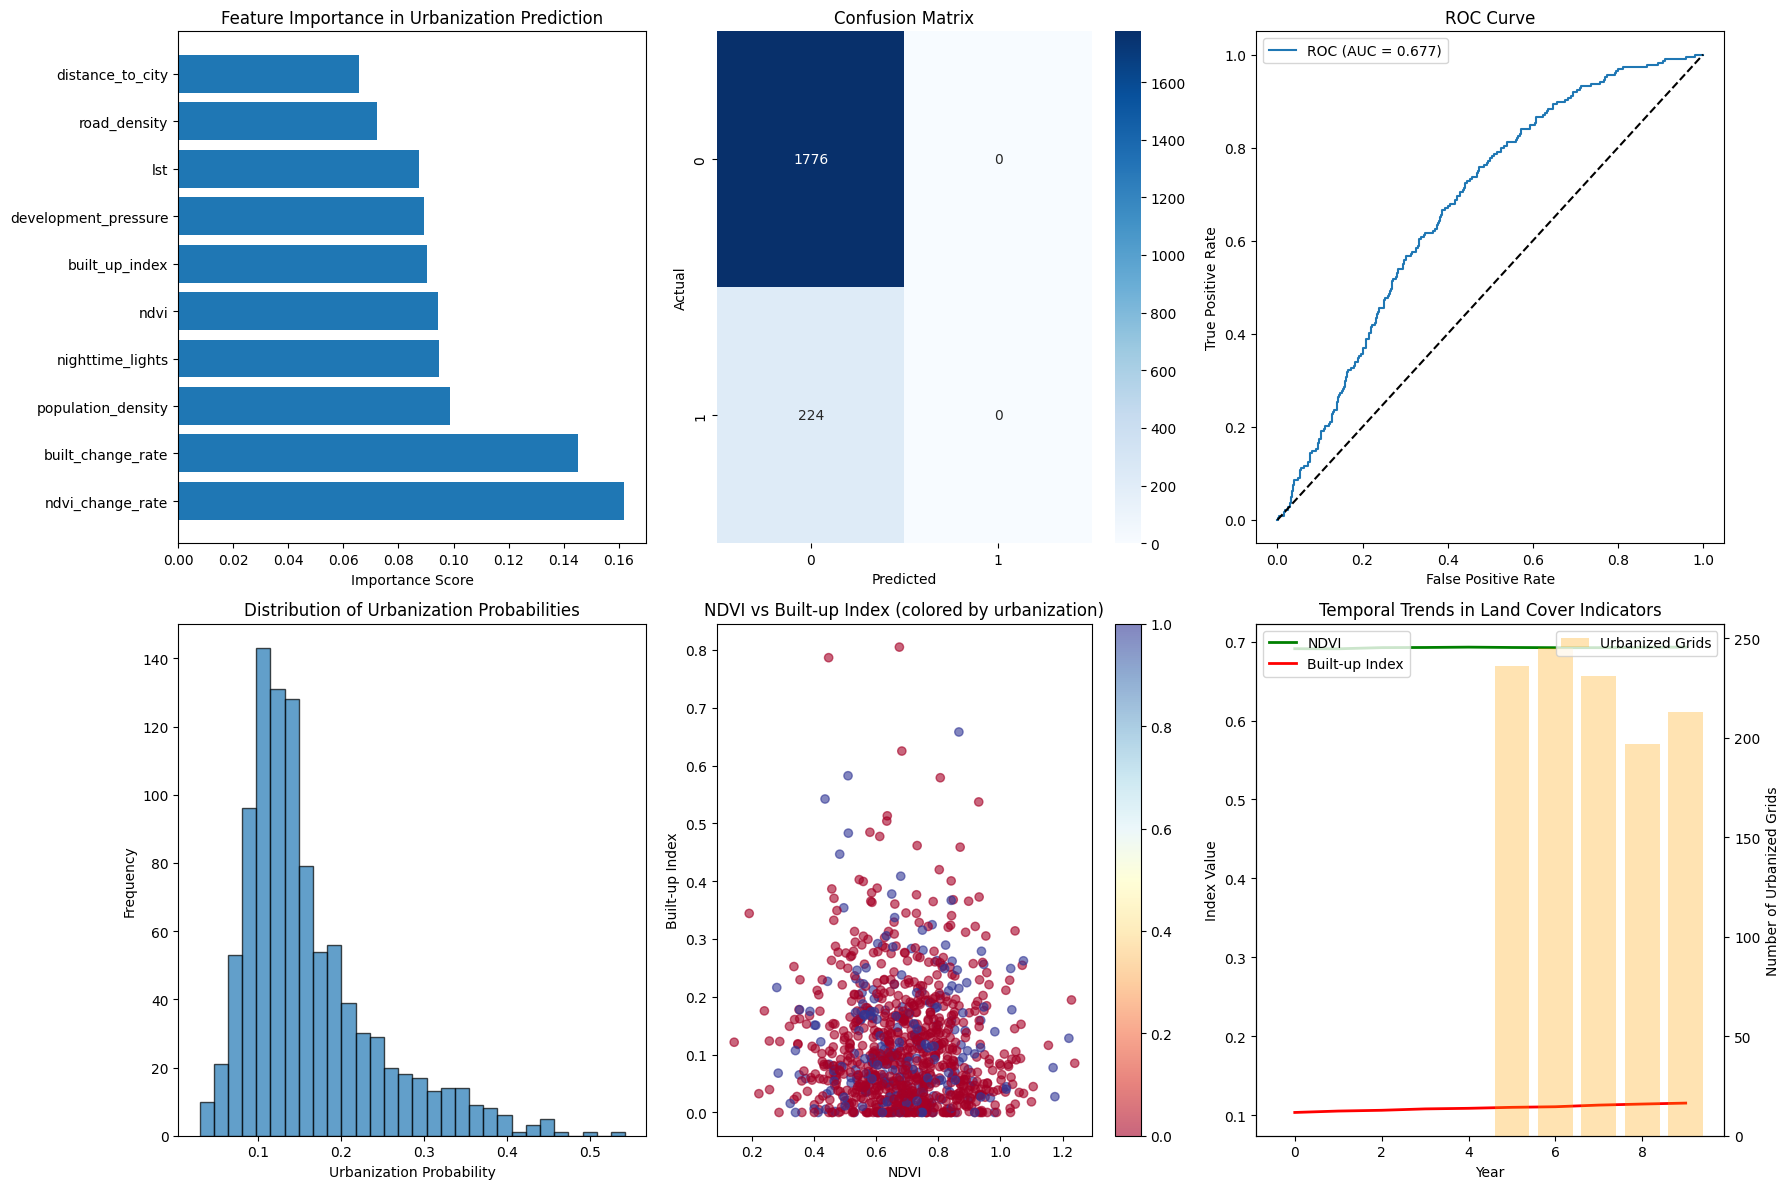


Generating Urbanization Risk Map...


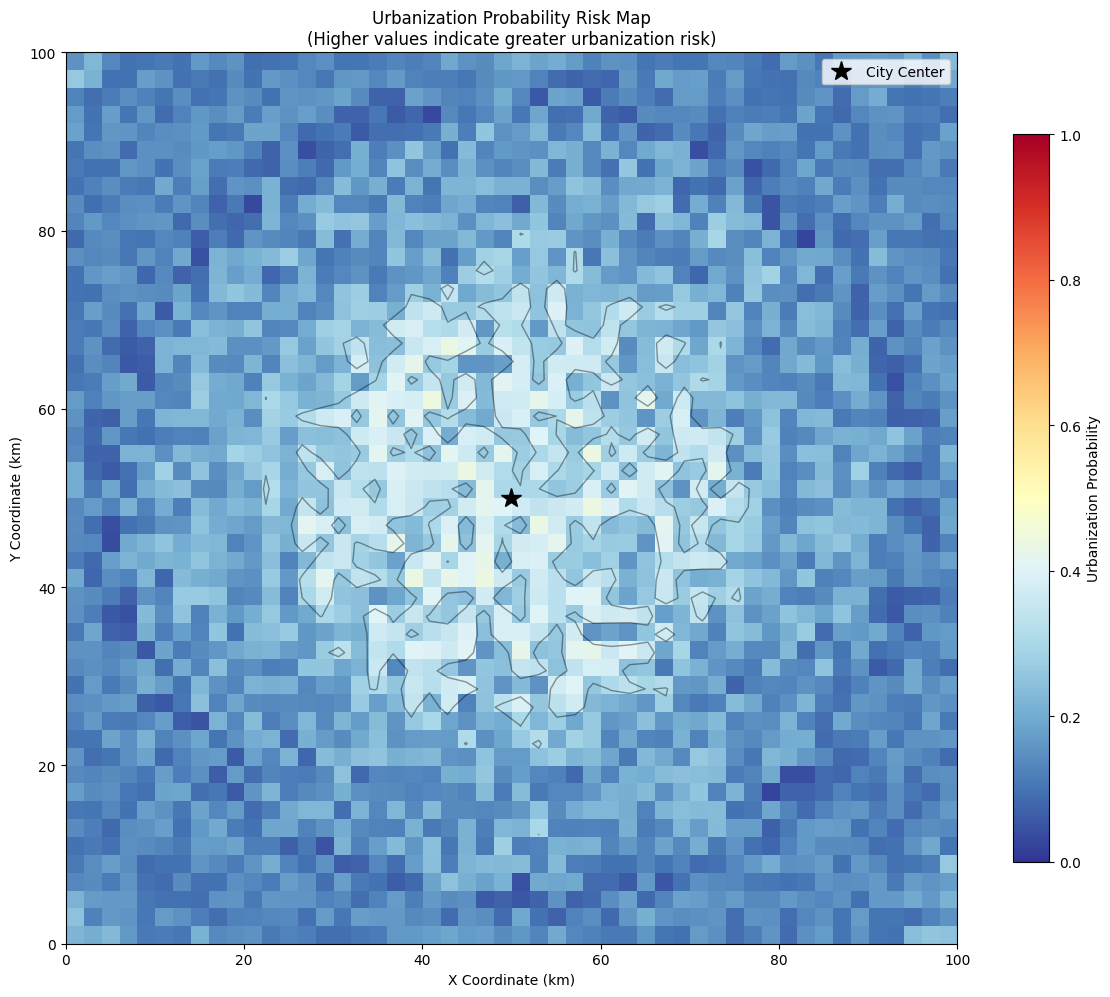


Risk Assessment Summary:
High Risk (>70% probability): 0 grids (0.0%)
Medium Risk (30-70% probability): 281 grids (11.2%)
Low Risk (<30% probability): 2219 grids (88.8%)

Example: Predicting urbanization for recent time period...

Sample Predictions:
    grid_id   ndvi  built_up_index  urbanization_probability  \
9         0  0.461           0.080                     0.134   
19        1  1.155           0.116                     0.154   
29        2  0.720           0.000                     0.106   
39        3  0.420           0.122                     0.276   
49        4  0.701           0.046                     0.222   
59        5  0.735           0.141                     0.242   
69        6  0.796           0.152                     0.180   
79        7  0.724           0.153                     0.074   
89        8  0.699           0.095                     0.139   
99        9  0.576           0.047                     0.265   

    predicted_urbanization  
9             

In [1]:
# Urbanization Probability Index System
# Predicts rural grid urbanization probability using satellite data and ML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Urbanization Probability Index System")
print("=====================================")
print("SDG 11 - Sustainable Cities and Communities")
print()

class UrbanizationPredictor:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.feature_importance = None
        self.grid_data = None

    def simulate_satellite_data(self, n_grids=1000, n_years=10):
        """
        Simulate multi-temporal satellite and auxiliary data
        Mimics Landsat/Sentinel-2 derived features
        """
        print(f"Generating simulated data for {n_grids} grid cells over {n_years} years...")

        # Initialize data structure
        data = []

        # Define urbanization probability based on initial conditions
        base_urban_prob = np.random.beta(2, 8, n_grids)  # Most areas start rural

        for grid_id in range(n_grids):
            # Initial conditions (year 0)
            initial_ndvi = np.random.normal(0.7, 0.15)  # High NDVI for rural areas
            initial_built_index = np.random.exponential(0.1)  # Low built-up initially

            # Infrastructure factors (remain relatively stable)
            road_density = np.random.exponential(2.0)  # km/km2
            dist_to_city = np.random.uniform(5, 50)  # km
            population_density = np.random.lognormal(3, 1)  # people/km2

            # Economic factors
            gdp_growth_rate = np.random.normal(0.03, 0.02)  # Annual growth

            # Track changes over years
            current_ndvi = initial_ndvi
            current_built = initial_built_index

            for year in range(n_years):
                # Simulate natural change and development pressure
                development_pressure = (road_density / dist_to_city) * (population_density / 1000)

                # NDVI decreases with development
                ndvi_change = np.random.normal(-development_pressure * 0.01, 0.02)
                current_ndvi = max(0.1, current_ndvi + ndvi_change)

                # Built-up index increases with development
                built_change = np.random.normal(development_pressure * 0.05, 0.02)
                current_built = max(0, current_built + built_change)

                # Land Surface Temperature (increases with urbanization)
                lst = 285 + (1 - current_ndvi) * 15 + np.random.normal(0, 2)

                # Nighttime lights (proxy for human activity)
                ntl = current_built * 10 + population_density * 0.01 + np.random.exponential(1)

                # Population growth
                population_density *= (1 + gdp_growth_rate + np.random.normal(0, 0.01))

                # Calculate change metrics (compared to year 0)
                if year == 0:
                    ndvi_change_rate = 0
                    built_change_rate = 0
                else:
                    ndvi_change_rate = (current_ndvi - initial_ndvi) / year
                    built_change_rate = (current_built - initial_built_index) / year

                # Determine if urbanization occurred (binary outcome)
                # Higher probability if significant built-up increase and NDVI decrease
                urbanization_prob = base_urban_prob[grid_id] * (1 + development_pressure)
                urbanization_prob += max(0, -ndvi_change_rate) * 2
                urbanization_prob += max(0, built_change_rate) * 3
                urbanization_prob = min(1, urbanization_prob)

                urbanized = np.random.binomial(1, urbanization_prob) if year >= 5 else 0

                # Store data
                data.append({
                    'grid_id': grid_id,
                    'year': year,
                    'ndvi': current_ndvi,
                    'built_up_index': current_built,
                    'lst': lst,
                    'nighttime_lights': ntl,
                    'road_density': road_density,
                    'distance_to_city': dist_to_city,
                    'population_density': population_density,
                    'ndvi_change_rate': ndvi_change_rate,
                    'built_change_rate': built_change_rate,
                    'development_pressure': development_pressure,
                    'urbanized': urbanized
                })

        self.grid_data = pd.DataFrame(data)
        print(f"Generated {len(self.grid_data)} data points")
        print(f"Urbanization rate: {self.grid_data['urbanized'].mean():.2%}")

        return self.grid_data

    def prepare_features(self, data):
        """
        Prepare feature matrix for machine learning
        """
        feature_columns = [
            'ndvi', 'built_up_index', 'lst', 'nighttime_lights',
            'road_density', 'distance_to_city', 'population_density',
            'ndvi_change_rate', 'built_change_rate', 'development_pressure'
        ]

        X = data[feature_columns].copy()
        y = data['urbanized'].copy()

        return X, y, feature_columns

    def train_model(self, data):
        """
        Train Random Forest model for urbanization prediction
        """
        print("\nTraining Random Forest model...")

        X, y, feature_names = self.prepare_features(data)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train Random Forest
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )

        self.model.fit(X_train_scaled, y_train)

        # Evaluate model
        train_score = self.model.score(X_train_scaled, y_train)
        test_score = self.model.score(X_test_scaled, y_test)

        # Cross-validation
        cv_scores = cross_val_score(self.model, X_train_scaled, y_train, cv=5)

        # Predictions for detailed metrics
        y_pred = self.model.predict(X_test_scaled)
        y_prob = self.model.predict_proba(X_test_scaled)[:, 1]

        print(f"Training Accuracy: {train_score:.3f}")
        print(f"Testing Accuracy: {test_score:.3f}")
        print(f"Cross-validation Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

        # Feature importance
        self.feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        return {
            'train_score': train_score,
            'test_score': test_score,
            'cv_scores': cv_scores,
            'auc_score': roc_auc_score(y_test, y_prob),
            'X_test': X_test_scaled,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_prob': y_prob
        }

    def predict_urbanization_probability(self, data):
        """
        Predict urbanization probability for new data
        """
        if self.model is None:
            raise ValueError("Model must be trained first")

        X, _, _ = self.prepare_features(data)
        X_scaled = self.scaler.transform(X)

        probabilities = self.model.predict_proba(X_scaled)[:, 1]
        predictions = self.model.predict(X_scaled)

        results = data.copy()
        results['urbanization_probability'] = probabilities
        results['predicted_urbanization'] = predictions

        return results

    def create_visualizations(self, results_dict):
        """
        Create comprehensive visualizations
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Feature Importance
        axes[0, 0].barh(self.feature_importance['feature'],
                       self.feature_importance['importance'])
        axes[0, 0].set_title('Feature Importance in Urbanization Prediction')
        axes[0, 0].set_xlabel('Importance Score')

        # 2. Confusion Matrix
        cm = confusion_matrix(results_dict['y_test'], results_dict['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
        axes[0, 1].set_title('Confusion Matrix')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')

        # 3. ROC Curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(results_dict['y_test'], results_dict['y_prob'])
        axes[0, 2].plot(fpr, tpr, label=f'ROC (AUC = {results_dict["auc_score"]:.3f})')
        axes[0, 2].plot([0, 1], [0, 1], 'k--')
        axes[0, 2].set_xlabel('False Positive Rate')
        axes[0, 2].set_ylabel('True Positive Rate')
        axes[0, 2].set_title('ROC Curve')
        axes[0, 2].legend()

        # 4. Probability Distribution
        prob_data = self.predict_urbanization_probability(
            self.grid_data[self.grid_data['year'] == self.grid_data['year'].max()]
        )

        axes[1, 0].hist(prob_data['urbanization_probability'], bins=30, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Urbanization Probability')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Distribution of Urbanization Probabilities')

        # 5. NDVI vs Built-up Index
        latest_data = self.grid_data[self.grid_data['year'] == self.grid_data['year'].max()]
        scatter = axes[1, 1].scatter(latest_data['ndvi'], latest_data['built_up_index'],
                                   c=latest_data['urbanized'], cmap='RdYlBu', alpha=0.6)
        axes[1, 1].set_xlabel('NDVI')
        axes[1, 1].set_ylabel('Built-up Index')
        axes[1, 1].set_title('NDVI vs Built-up Index (colored by urbanization)')
        plt.colorbar(scatter, ax=axes[1, 1])

        # 6. Time Series of Key Indicators
        time_series = self.grid_data.groupby('year').agg({
            'ndvi': 'mean',
            'built_up_index': 'mean',
            'urbanized': 'sum'
        }).reset_index()

        ax2 = axes[1, 2].twinx()
        axes[1, 2].plot(time_series['year'], time_series['ndvi'], 'g-', label='NDVI', linewidth=2)
        axes[1, 2].plot(time_series['year'], time_series['built_up_index'], 'r-', label='Built-up Index', linewidth=2)
        ax2.bar(time_series['year'], time_series['urbanized'], alpha=0.3, color='orange', label='Urbanized Grids')

        axes[1, 2].set_xlabel('Year')
        axes[1, 2].set_ylabel('Index Value')
        ax2.set_ylabel('Number of Urbanized Grids')
        axes[1, 2].set_title('Temporal Trends in Land Cover Indicators')
        axes[1, 2].legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    def generate_risk_map(self, n_grids_x=50, n_grids_y=50):
        """
        Generate a spatial risk map of urbanization probability
        """
        print("\nGenerating Urbanization Risk Map...")

        # Create spatial grid
        x_coords = np.linspace(0, 100, n_grids_x)
        y_coords = np.linspace(0, 100, n_grids_y)
        X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

        # Generate features for spatial prediction
        spatial_data = []

        for i, x in enumerate(x_coords):
            for j, y in enumerate(y_coords):
                # Distance to center (simulated city center)
                dist_to_center = np.sqrt((x - 50)**2 + (y - 50)**2)

                # Simulate realistic features based on location
                road_density = max(0.1, 10 * np.exp(-dist_to_center / 20))
                population_density = max(10, 1000 * np.exp(-dist_to_center / 15))

                # Environmental factors
                ndvi = min(0.9, 0.3 + dist_to_center / 100)
                built_up = max(0, 2 - dist_to_center / 25)
                lst = 285 + (1 - ndvi) * 10
                ntl = built_up * 5 + population_density * 0.005

                # Change rates (simulated)
                ndvi_change = np.random.normal(-0.01, 0.005)
                built_change = np.random.normal(0.02, 0.01)
                dev_pressure = (road_density / max(1, dist_to_center)) * (population_density / 1000)

                spatial_data.append({
                    'x_coord': x,
                    'y_coord': y,
                    'ndvi': ndvi,
                    'built_up_index': built_up,
                    'lst': lst,
                    'nighttime_lights': ntl,
                    'road_density': road_density,
                    'distance_to_city': dist_to_center,
                    'population_density': population_density,
                    'ndvi_change_rate': ndvi_change,
                    'built_change_rate': built_change,
                    'development_pressure': dev_pressure,
                    'urbanized': 0  # placeholder
                })

        spatial_df = pd.DataFrame(spatial_data)

        # Predict urbanization probability
        predictions = self.predict_urbanization_probability(spatial_df)

        # Reshape for plotting
        prob_grid = predictions['urbanization_probability'].values.reshape(n_grids_y, n_grids_x)

        # Create risk map
        plt.figure(figsize=(12, 10))

        im = plt.imshow(prob_grid, extent=[0, 100, 0, 100], origin='lower',
                       cmap='RdYlBu_r', vmin=0, vmax=1)

        plt.colorbar(im, label='Urbanization Probability', shrink=0.8)
        plt.contour(X_grid, Y_grid, prob_grid, levels=[0.3, 0.5, 0.7, 0.9],
                   colors='black', alpha=0.4, linewidths=1)

        plt.xlabel('X Coordinate (km)')
        plt.ylabel('Y Coordinate (km)')
        plt.title('Urbanization Probability Risk Map\n(Higher values indicate greater urbanization risk)')

        # Add city center marker
        plt.plot(50, 50, 'k*', markersize=15, label='City Center')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Risk statistics
        high_risk = (predictions['urbanization_probability'] > 0.7).sum()
        medium_risk = ((predictions['urbanization_probability'] > 0.3) &
                      (predictions['urbanization_probability'] <= 0.7)).sum()
        low_risk = (predictions['urbanization_probability'] <= 0.3).sum()

        print(f"\nRisk Assessment Summary:")
        print(f"High Risk (>70% probability): {high_risk} grids ({high_risk/len(predictions)*100:.1f}%)")
        print(f"Medium Risk (30-70% probability): {medium_risk} grids ({medium_risk/len(predictions)*100:.1f}%)")
        print(f"Low Risk (<30% probability): {low_risk} grids ({low_risk/len(predictions)*100:.1f}%)")

        return predictions

# Main execution
def main():
    # Initialize predictor
    predictor = UrbanizationPredictor()

    # Generate simulated data
    data = predictor.simulate_satellite_data(n_grids=1000, n_years=10)

    # Display data summary
    print("\nData Summary:")
    print(data.describe())

    # Train model
    results = predictor.train_model(data)

    # Display feature importance
    print("\nFeature Importance:")
    print(predictor.feature_importance)

    # Create visualizations
    predictor.create_visualizations(results)

    # Generate risk map
    risk_map = predictor.generate_risk_map()

    # Example prediction for new data
    print("\nExample: Predicting urbanization for recent time period...")
    latest_data = data[data['year'] == data['year'].max()].head(10)
    predictions = predictor.predict_urbanization_probability(latest_data)

    print("\nSample Predictions:")
    print(predictions[['grid_id', 'ndvi', 'built_up_index', 'urbanization_probability',
                      'predicted_urbanization']].round(3))

    print("\n" + "="*60)
    print("URBANIZATION PROBABILITY INDEX ANALYSIS COMPLETE")
    print("="*60)
    print("This system supports SDG 11 - Sustainable Cities and Communities")
    print("by providing early warning for urbanization patterns.")
    print("Use this tool for:")
    print("- Urban planning and zoning")
    print("- Infrastructure development prioritization")
    print("- Environmental impact assessment")
    print("- Policy intervention targeting")

if __name__ == "__main__":
    main()